<a href="https://colab.research.google.com/github/AKASH4671/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/blob/main/04_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import libraries**

In [40]:
!pip install xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    auc,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap

**Load dataset**

In [9]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/data/cleaned data/lendingclub_final_model_ready.csv'
df = pd.read_csv(file_path, low_memory=False)
df.head()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,disbursement_method_DirectPay
0,3600.0,3600.0,13.99,123.03,55000.0,5.91,0.0,675.0,679.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,11.99,820.28,65000.0,16.06,1.0,715.0,719.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,20000.0,20000.0,10.78,432.66,63000.0,10.78,0.0,695.0,699.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10400.0,10400.0,22.45,289.91,104433.0,25.37,1.0,695.0,699.0,3.0,...,0,1,0,0,0,0,0,0,0,0
4,11950.0,11950.0,13.44,405.18,34000.0,10.20,0.0,690.0,694.0,0.0,...,0,0,0,0,0,0,0,0,0,0


**Split Features and Target**

In [10]:
# Target = loan_default | Features = all else
X = df.drop('loan_default', axis=1)
y = df['loan_default']

**Train-Test Split**

In [12]:
# 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

**Logistic Regression**

In [14]:
# Initialize and train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Evaluation Metrics**

In [15]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94    215350
           1       0.79      0.64      0.71     53720

    accuracy                           0.89    269070
   macro avg       0.85      0.80      0.82    269070
weighted avg       0.89      0.89      0.89    269070

Confusion Matrix:
 [[206110   9240]
 [ 19354  34366]]
ROC AUC Score: 0.9403995331501593


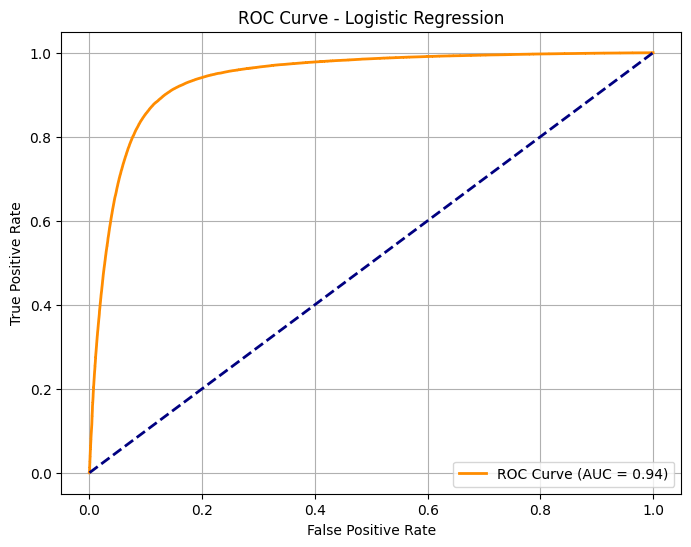

In [17]:
# Get FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Handle Imbalance via :**
1. SMOTE (Synthetic Minority Over-sampling Technique)


2. Class Weights  

 2.1 Feature Importance



In [21]:
# 1. Apply SMOTE on training set only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 2. Fit Logistic Regression on SMOTE data
lr_smote = LogisticRegression(max_iter=1000)
lr_smote.fit(X_train_sm, y_train_sm)

# 3. Predict
y_pred_sm = lr_smote.predict(X_test)
y_prob_sm = lr_smote.predict_proba(X_test)[:, 1]

# 4. Evaluation
print("Logistic Regression with SMOTE")
print(classification_report(y_test, y_pred_sm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sm))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_sm))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       0.96      0.89      0.93    215350
           1       0.67      0.86      0.76     53720

    accuracy                           0.89    269070
   macro avg       0.82      0.88      0.84    269070
weighted avg       0.91      0.89      0.89    269070

Confusion Matrix:
 [[192720  22630]
 [  7341  46379]]
ROC AUC Score: 0.9398301990162684


In [19]:
# 1. Train model with class weighting
lr_weighted = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_weighted.fit(X_train, y_train)

# 2. Predict
y_pred_wt = lr_weighted.predict(X_test)
y_prob_wt = lr_weighted.predict_proba(X_test)[:, 1]

# 3. Evaluation
print("Logistic Regression with Class Weights")
print(classification_report(y_test, y_pred_wt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_wt))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_wt))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression with Class Weights
              precision    recall  f1-score   support

           0       0.97      0.89      0.93    215350
           1       0.66      0.87      0.75     53720

    accuracy                           0.89    269070
   macro avg       0.81      0.88      0.84    269070
weighted avg       0.90      0.89      0.89    269070

Confusion Matrix:
 [[191338  24012]
 [  6860  46860]]
ROC AUC Score: 0.9398395412859739


In [22]:
# 1. Get feature names and coefficients
feature_names = X.columns
coefficients = lr_weighted.coef_[0]

# 2. Create DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# 3. Sort by absolute impact
importance_df['Abs_Coefficient'] = np.abs(importance_df['Coefficient'])
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# 4. Top 15 important features
importance_df.head(15)

,Feature,Coefficient,Abs_Coefficient
18,last_fico_range_low,-0.019742,0.019742
8,fico_range_high,0.013113,0.013113
7,fico_range_low,0.013021,0.013021
17,last_fico_range_high,-0.011817,0.011817
66,pct_tl_nvr_dlq,0.002009,0.002009
28,il_util,0.001784,0.001784
44,mo_sin_old_rev_tl_op,0.001686,0.001686
40,bc_util,0.001625,0.001625
11,mths_since_last_record,0.001605,0.001605
67,percent_bc_gt_75,0.001600,0.001600


  **1. XGBoost Model + SHAP:feature interpretability**

  1.1 Feature Importance by XGBoost Built in

In [25]:
# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=4,  # helps with class imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Clean column names
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]
X_test.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_test.columns]

# Fit model
xgb_clf.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:59:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [26]:
# Evaluate XGBoost Model
print(" XGBoost Evaluation")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob_xgb))


 XGBoost Evaluation
              precision    recall  f1-score   support

           0       0.98      0.88      0.92    215350
           1       0.65      0.91      0.76     53720

    accuracy                           0.88    269070
   macro avg       0.81      0.90      0.84    269070
weighted avg       0.91      0.88      0.89    269070

Confusion Matrix:
 [[188942  26408]
 [  4624  49096]]
ROC AUC Score: 0.9550812422278854


In [ ]:
# SHAP: Feature Interpretability

# Create TreeExplainer
explainer = shap.Explainer(xgb_clf)

# Get SHAP values for test set
shap_values = explainer(X_test)

In [30]:
# Extract SHAP Values (Numerically)

# Mean absolute SHAP value per feature
shap_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP_Impact': np.abs(shap_values.values).mean(axis=0)
})

# Sort by importance
shap_df_sorted = shap_df.sort_values(by='Mean_SHAP_Impact', ascending=False).reset_index(drop=True)

In [31]:
# Display top 20
shap_df_sorted.head(20)

,Feature,Mean_SHAP_Impact
0,last_fico_range_high,2.126556
1,last_fico_range_low,0.563269
2,term__60_months,0.238753
3,annual_inc,0.118678
4,mo_sin_old_rev_tl_op,0.106887
5,dti,0.099146
6,loan_amnt,0.098909
7,emp_length_10__years,0.090285
8,int_rate,0.082507
9,fico_range_low,0.068785


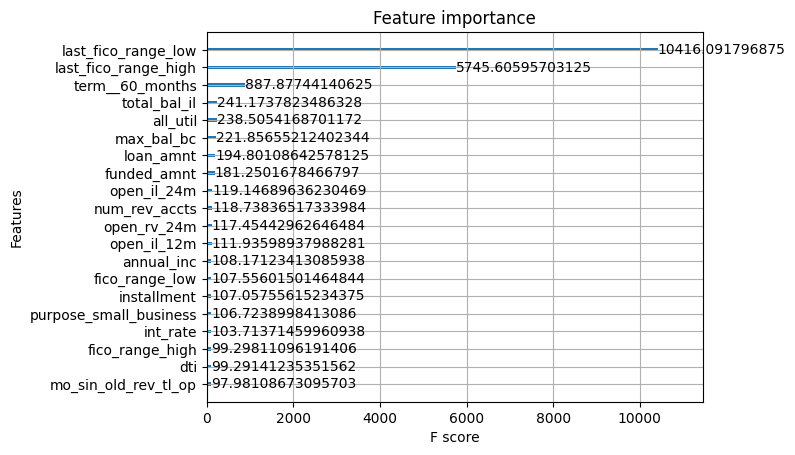

In [28]:
# Feature Importance by XGBoost Built-in
xgb.plot_importance(xgb_clf, max_num_features=20, importance_type='gain')
plt.show()

**Logistic Regression save CSV**

In [34]:
# Outputs for Baseline Logistic Regression (No SMOTE / No Class Weights)
report_lr = classification_report(y_test, y_pred, output_dict=True)
report_df_lr = pd.DataFrame(report_lr).transpose()
report_df_lr.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_classic_classification_report.csv", index=True)

cm_lr = confusion_matrix(y_test, y_pred)
cm_lr_df = pd.DataFrame(cm_lr, columns=["Pred_0", "Pred_1"], index=["Actual_0", "Actual_1"])
cm_lr_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_classic_confusion_matrix.csv")

roc_lr = roc_auc_score(y_test, y_prob)
with open("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_classic_roc_auc.txt", "w") as f:
    f.write(f"Logistic Regression (No SMOTE/Class Weight) ROC AUC: {roc_lr}\n")

# Logistic Regression with SMOTE
report_smote = classification_report(y_test, y_pred_sm, output_dict=True)
report_df_smote = pd.DataFrame(report_smote).transpose()
report_df_smote.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_smote_classification_report.csv", index=True)

# Logistic Regression with Class Weights
report_weighted = classification_report(y_test, y_pred_wt, output_dict=True)
report_df_weighted = pd.DataFrame(report_weighted).transpose()
report_df_weighted.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_weighted_classification_report.csv", index=True)

# SMOTE Confusion Matrix
cm_smote = confusion_matrix(y_test, y_pred_sm)
pd.DataFrame(cm_smote, columns=["Pred_0", "Pred_1"], index=["Actual_0", "Actual_1"])\
  .to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_smote_confusion_matrix.csv")

# Class Weights Confusion Matrix
cm_weighted = confusion_matrix(y_test, y_pred_wt)
pd.DataFrame(cm_weighted, columns=["Pred_0", "Pred_1"], index=["Actual_0", "Actual_1"])\
  .to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_weighted_confusion_matrix.csv")

# ROC AUC Score
roc_smote = roc_auc_score(y_test, y_prob_sm)
roc_weighted = roc_auc_score(y_test, y_prob_wt)
with open("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/lr_roc_auc_scores.txt", "w") as f:
    f.write(f"Logistic Regression (SMOTE) ROC AUC: {roc_smote}\n")
    f.write(f"Logistic Regression (Class Weights) ROC AUC: {roc_weighted}\n")

**XGBoost save CSV**

In [36]:
# save SHAP Feature Impoertance as CSV
shap_df_sorted.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/shap_feature_importance.csv", index=False)

# Save Classification Report (XGBoost)
report = classification_report(y_test, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/xgb_classification_report.csv", index=True)

# Save Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
cm_df = pd.DataFrame(cm, columns=['Predicted_0', 'Predicted_1'], index=['Actual_0', 'Actual_1'])

cm_df.to_csv("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/xgb_confusion_matrix.csv")

# Save ROC AUC Score
roc_score_xgb = roc_auc_score(y_test, y_prob_xgb)
with open("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/outputs/xgb_roc_auc.txt", "w") as f:
    f.write(f"ROC AUC Score: {roc_score_xgb}")

**Plots**

In [42]:
# Store model names, predictions, and probabilities
models = {
    "LogReg Base": (y_pred, y_prob),
    "LogReg SMOTE": (y_pred_sm, y_prob_sm),
    "LogReg Weights": (y_pred_wt, y_prob_wt),
    "XGBoost": (y_pred_xgb, y_prob_xgb)
}

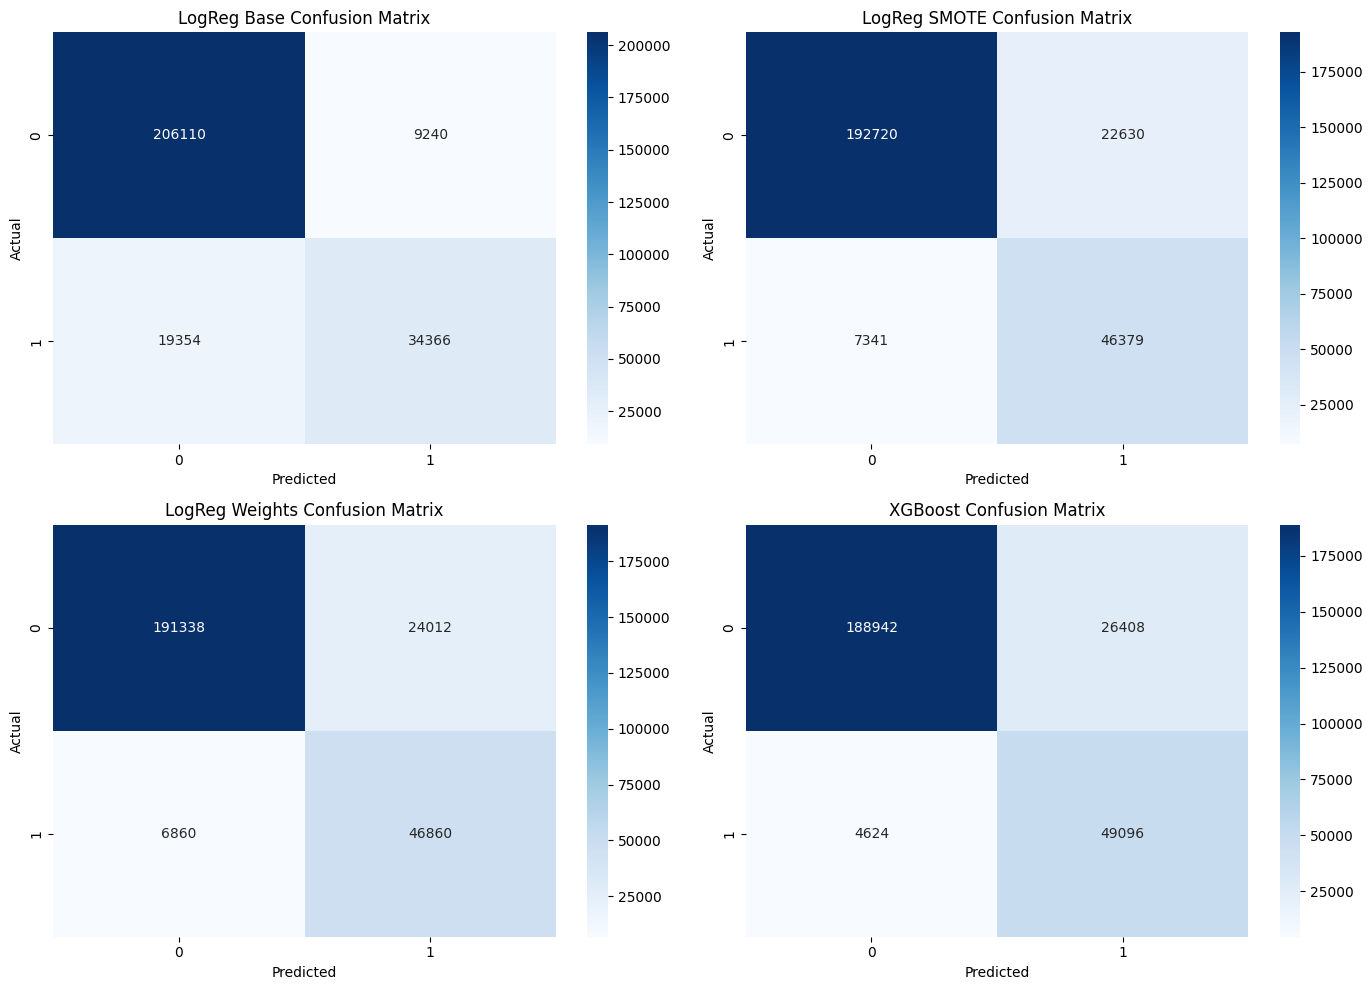

In [43]:
# 1. Confusion Matrix Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
for i, (name, (ypred, _)) in enumerate(models.items()):
    cm = confusion_matrix(y_test, ypred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/images/confusion_matrices.png", dpi=300)

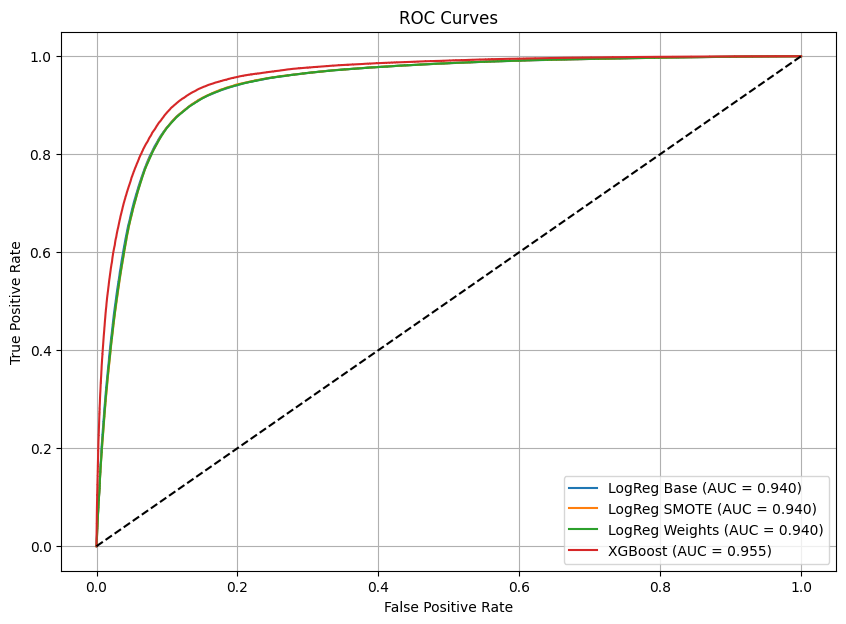

In [44]:
# 2. ROC Curve Plot
plt.figure(figsize=(10, 7))
for name, (_, yprob) in models.items():
    fpr, tpr, _ = roc_curve(y_test, yprob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/images/roc_curves.png", dpi=300)

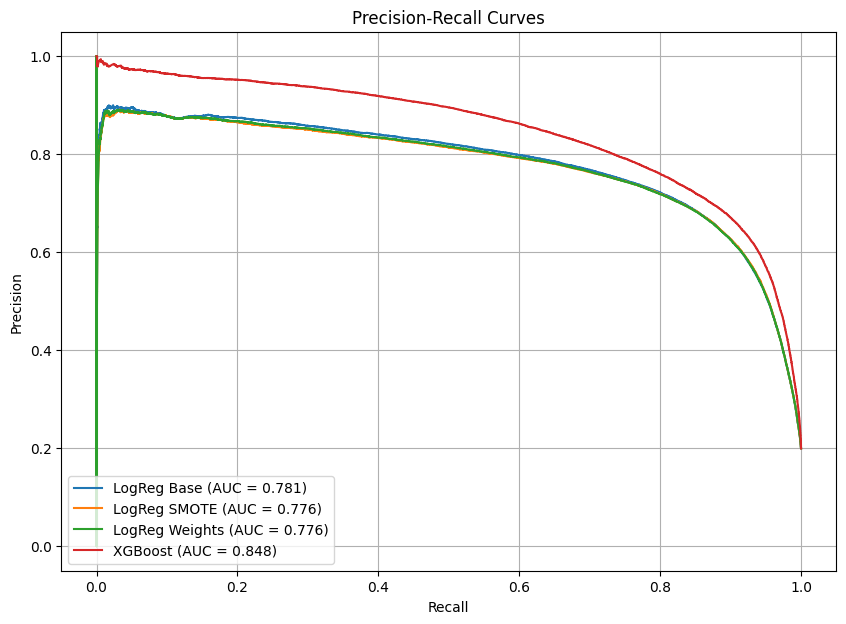

In [45]:
# 3. Precision-Recall Curve
plt.figure(figsize=(10, 7))
for name, (_, yprob) in models.items():
    precision, recall, _ = precision_recall_curve(y_test, yprob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.3f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/images/precision_recall_curves.png", dpi=300)

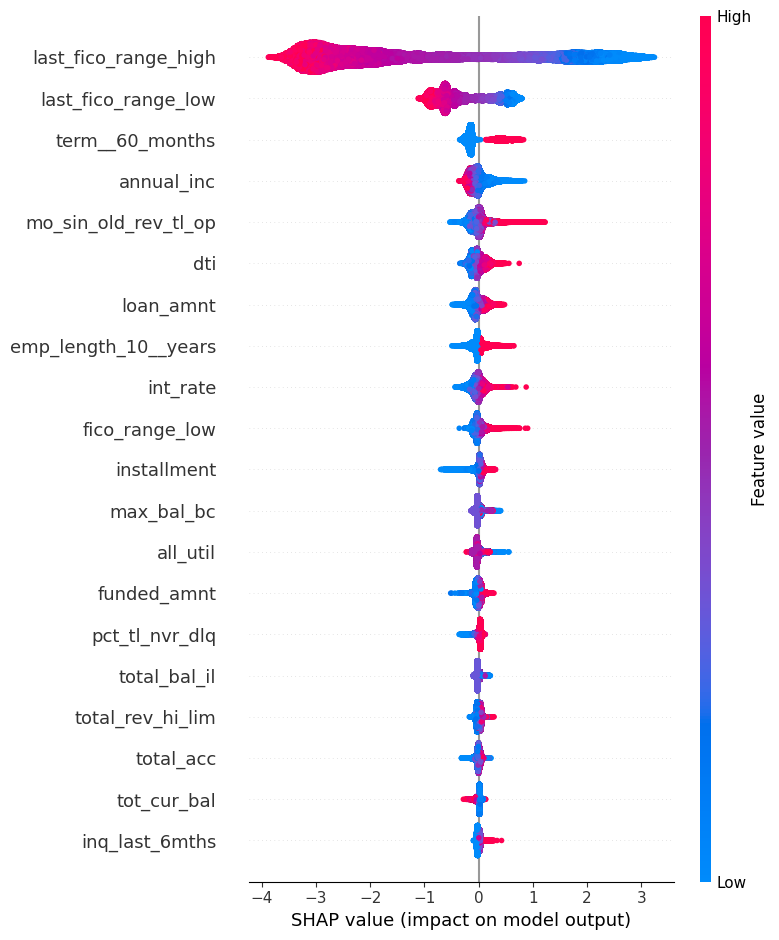

In [46]:
# 4. SHAP Summary Plot
shap.summary_plot(shap_values, X_test)

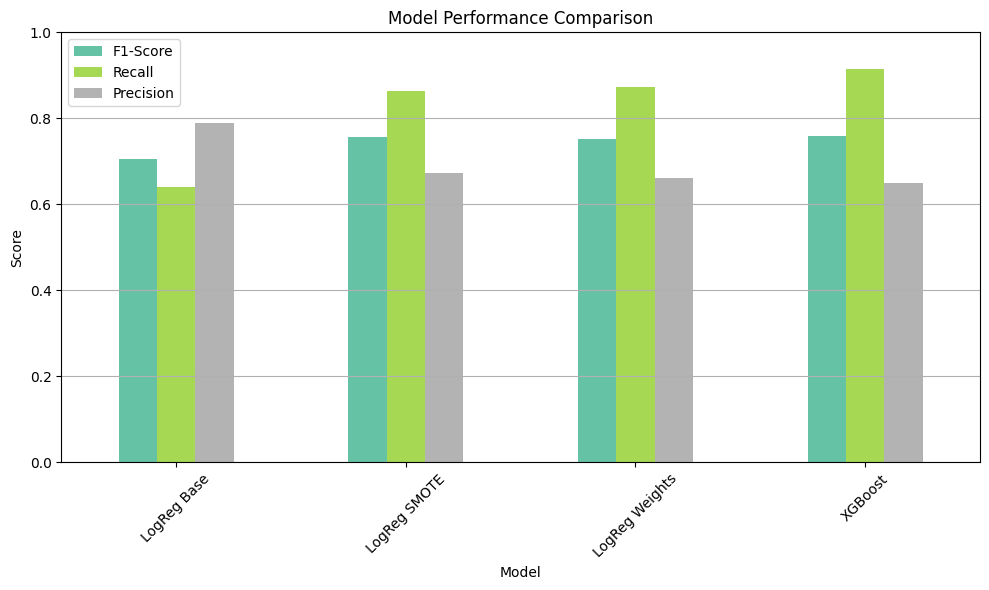

In [47]:
# 5. Bar Plot of F1-score and Recall
scores = {
    "Model": [],
    "F1-Score": [],
    "Recall": [],
    "Precision": []
}

for name, (ypred, yprob) in models.items():
    scores["Model"].append(name)
    scores["F1-Score"].append(f1_score(y_test, ypred))
    scores["Recall"].append(recall_score(y_test, ypred))
    scores["Precision"].append(precision_score(y_test, ypred))

score_df = pd.DataFrame(scores)
score_df.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="Set2")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/Colab Notebooks/Finance Projects/AI-Driven-Credit-Risk-Prediction-and-Crisis-Resilience-Analysis/images/model_comparison_barplot.png", dpi=300)